# Xtream AI assignement - Challenge 1 - Model Selection

## Purpose
The outcome of this notebook will be a model that predicts a gem's worth based on its characteristics.


## Evaluation metrics:
I select evaluation metrics to assess the performance of the regression models:
- Root Mean Squared Error (RMSE): Measures the average deviation of the predicted values from the actual values.
- R-squared (R2) Score: Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.
- Mean Absolute Error (MAE): Measures the average absolute errors between the predicted and actual values.

## Model:
Possible regression models to try

- Linear Regression:
Algorithm for predicting continuous values. It assumes a linear relationship between the input features (such as carat weight, cut quality, color, and clarity) and the output variable (diamond price). The model computes a weighted sum of input features, along with a bias term.

- Decision Tree Regression:
Decision trees are versatile models that can handle both regression and classification tasks.
They split the data into segments based on feature values and predict the average target value within each segment.
Decision tree regression models can capture non-linear relationships between features and target variables.

- Random Forest Regression:
Random Forests are ensembles of decision trees.
They combine multiple decision trees to improve prediction accuracy and reduce overfitting.
Random Forests can handle complex relationships and provide feature importance scores.

- Gradient Boosting Regression:
Gradient Boosting builds an ensemble of weak learners (usually decision trees) sequentially.
Each new tree corrects the errors made by the previous ones. 
 

## Library import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import time

RAND_STATE=37
FEAT=['depth','table','x','cut','color','clarity','carat']

## Import data

In [2]:
## Load the data
df = pd.read_csv('../datasets/diamonds/clean_data.csv')
df

,depth,table,x,cut_enc,color_enc,clarity_enc,log_price,log_carat
0,62.0,55.0,6.61,4,18,1,8.462315,0.095310
1,62.6,56.0,6.96,4,18,2,8.767796,0.254642
2,61.1,58.0,6.88,3,17,2,8.614320,0.182322
3,60.9,56.0,7.43,4,20,2,9.079092,0.405465
4,61.7,57.0,6.17,2,20,3,8.410276,-0.105361
...,...,...,...,...,...,...,...,...
4407,62.3,53.3,4.65,4,18,5,6.723832,-0.967584
4408,61.3,59.0,4.45,3,19,5,6.831954,-1.108663
4409,62.1,56.0,6.81,4,16,5,8.696176,0.223144
4410,62.9,58.0,4.31,3,20,3,6.687109,-1.171183


Rename the columns

In [3]:
column_name_mapping = {'cut_enc': 'cut', 'color_enc': 'color','clarity_enc':'clarity', 'log_price':'price','log_carat':'carat' }
df = df.rename(columns=column_name_mapping)
df

,depth,table,x,cut,color,clarity,price,carat
0,62.0,55.0,6.61,4,18,1,8.462315,0.095310
1,62.6,56.0,6.96,4,18,2,8.767796,0.254642
2,61.1,58.0,6.88,3,17,2,8.614320,0.182322
3,60.9,56.0,7.43,4,20,2,9.079092,0.405465
4,61.7,57.0,6.17,2,20,3,8.410276,-0.105361
...,...,...,...,...,...,...,...,...
4407,62.3,53.3,4.65,4,18,5,6.723832,-0.967584
4408,61.3,59.0,4.45,3,19,5,6.831954,-1.108663
4409,62.1,56.0,6.81,4,16,5,8.696176,0.223144
4410,62.9,58.0,4.31,3,20,3,6.687109,-1.171183


## Split data in train and test set

Dataset split to test the performances of the model:
- 80% training
- 20% test  

In [4]:
X = df.drop(columns=['price'])
y = df['price']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RAND_STATE)

## Scale data
I standardize the features with StandardScaler.  
It performs a z-score normalization: data is transformed to have a mean of 0 and a standard deviation of 1.
It first calculates std and mean on training data and transforms it, then it transforms the test data using the parameters calculated on train data. 

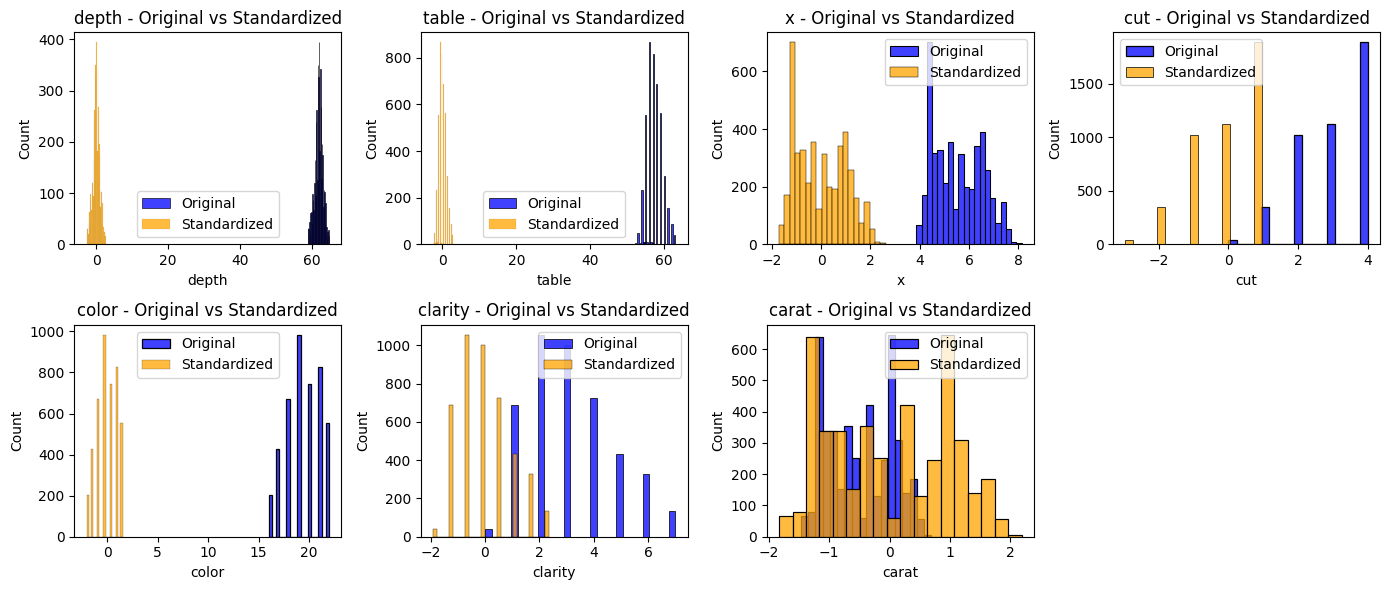

In [5]:
#### Standardize the features and visualize the result
scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
 
X_train = pd.DataFrame(X_train, columns =FEAT )
X_test = pd.DataFrame(X_test, columns =FEAT)
merged_df = pd.concat([X_train, X_test], ignore_index=True)


# Plot original vs standardized features
plt.figure(figsize=(14, 6))
for i, feature in enumerate(FEAT):
    plt.subplot(2, 4, i+1)
    sns.histplot(df[feature], color='blue', label='Original')
    sns.histplot(merged_df[feature], color='orange', label='Standardized')
    plt.title(f'{feature} - Original vs Standardized')
    plt.legend()
plt.tight_layout()
plt.show()


In [6]:
def plot(y_test, y_pred_linear,name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot 1: Correct Values vs Predicted Values
    ax1 = axes[0]
    sns.scatterplot(x=y_test, y=y_pred_linear, ax=ax1, color='blue', alpha=0.5)
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=ax1, color='red', linestyle='--')
    plt.title(f'{name} - Predicted vs Ground Truth Values')
    ax1.set_xlabel('Correct Values')
    ax1.set_ylabel('Predicted Values')

    # Plot 2: Residuals vs Fitted Values
    ax2 = axes[1]
    residuals = y_test - y_pred_linear
    sns.scatterplot(x=y_pred_linear, y=residuals, ax=ax2, color='blue', alpha=0.5)
    ax2.axhline(y=0, color='red', linestyle='--')
    plt.title(f'{name} - Residuals vs Ground Truth Values')
    ax2.set_xlabel("Fitted Values")
    ax2.set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

In [7]:
def plot_feature_importance(model, feature_names, model_type='linear_regression'):
 
    if model_type == 'linear_regression' or model_type == 'SVR':
        # Extract coefficients
        feature_importances = model.coef_

    elif model_type == 'Random Forest' or model_type == 'Decision Tree' or model_type == 'XGBoost':
        # Extract feature importances
        feature_importances = model.feature_importances_
    
    # Create a dictionary to store feature names and their importances
    feature_importance_dict = dict(zip(feature_names, feature_importances))
    
    # Sort feature importances in descending order of magnitude
    sorted_feature_importances = {k: v for k, v in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)}
    
    # Extract sorted feature names
    sorted_features = list(sorted_feature_importances.keys())
    feature_values = list(sorted_feature_importances.values())

    # Plot feature importances or coefficients
    plt.figure(figsize=(4, 4))
    plt.barh(sorted_features, feature_values)
    plt.xlabel('Feature Importance' if model_type == 'random_forest' else 'Feature Coefficient')
    plt.ylabel('Feature')
    plt.title(f'{model_type.capitalize()} Feature Importance' if model_type == 'random_forest' else f'{model_type.capitalize()} Feature Coefficients')

    plt.show()

## Linear Regression 
First I use the linear regression as a baseline.

Linear Regression Model: 
RMSE: 0.14070099145110454, 
R2 Score: 0.9773502711644247, 
MAE: 0.11027029131630986,  
Training Time: 0.0059812068939208984 seconds


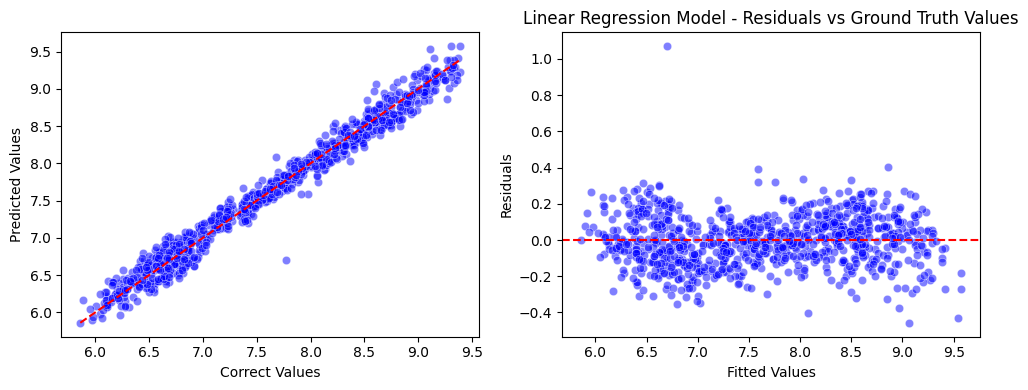

In [8]:
from sklearn.metrics import confusion_matrix
start_time = time.time()
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2 = r2_score(y_test, y_pred_linear)
mae = mean_absolute_error(y_test, y_pred_linear)

results = {}
name="Linear Regression Model"
results[name] = {'RMSE': rmse, 'R2 Score': r2, 'MAE': mae, 'Training Time': training_time}
print(f'{name}: \nRMSE: {rmse}, \nR2 Score: {r2}, \nMAE: {mae},  \nTraining Time: {training_time} seconds')
plot(y_test, y_pred_linear,name)


# Feature influence
Analyze the importance of different features in predicting the target variable using the coeffcients

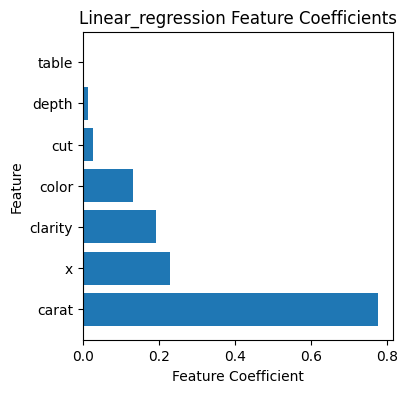

In [9]:
plot_feature_importance(linear_model, FEAT, 'linear_regression')

In [10]:
# Define models
models = {
    #'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=RAND_STATE),
    'XGBoost': XGBRegressor(seed=RAND_STATE, objective='reg:squarederror'), 
    'Random Forest': RandomForestRegressor(random_state=RAND_STATE),
}

### GridSearch: 

Grid search tries out different combinations of hyperparameters for a model to see which one works best. 
It does this by training and testing the model with each combination and picking the one that gives the best results.



#### XGBoost Hyperparameters

- n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
- max_depth: The maximum depth of each tree, often values are between 1 and 10.
- eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

#### SVR Hyperparameters
- C (Regularization Parameter): Determines the trade-off between maximizing the margin and minimizing the error. A smaller C value allows for a wider margin but may lead to more violations of the margin, while a larger C value penalizes violations more heavily.
- Kernel Type: The kernel function used for mapping the input features into a higher-dimensional space.  
- Gamma (Kernel Coefficient): Only relevant for kernel types other than linear. It defines how far the influence of a single training example reaches. A low gamma value means a large similarity radius, while a high gamma value means a smaller similarity radius.

In [11]:

# Define hyperparameters for grid search
param_grid = {
    'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 3]
    },   

    'Decision Tree':   {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
    },
    'XGBoost': {
            'n_estimators': [100, 250],
            'max_depth': [3, 5],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.6, 0.9],
            'colsample_bytree': [0.6, 0.9],
        } ,
}



Results:
Decision Tree - 
RMSE: 0.13745749100726384, 
R2 Score: 0.9783824975626846, 
MAE: 0.10331626011145555, 
Training Time: 1.8052523136138916 seconds, 
best_params {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


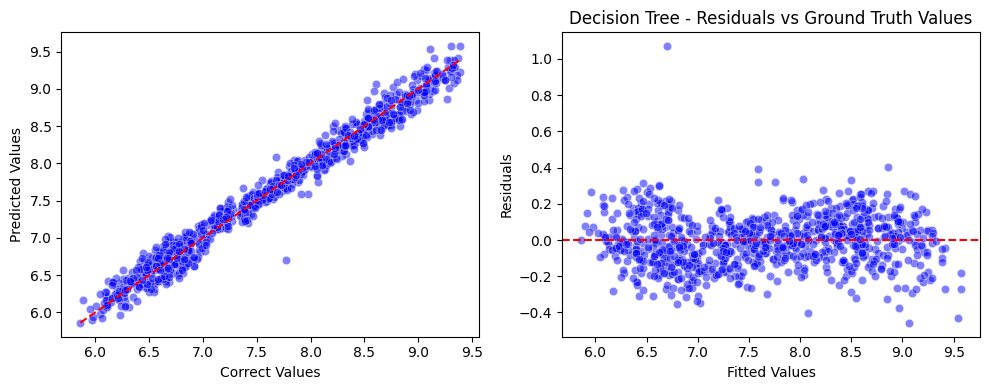

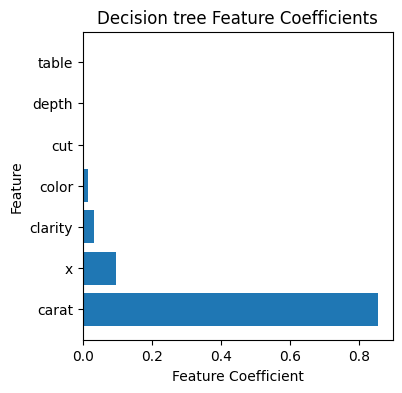


Results:
XGBoost - 
RMSE: 0.1040753126278654, 
R2 Score: 0.9876073512694312, 
MAE: 0.07494533152425986, 
Training Time: 21.74824857711792 seconds, 
best_params {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.9}


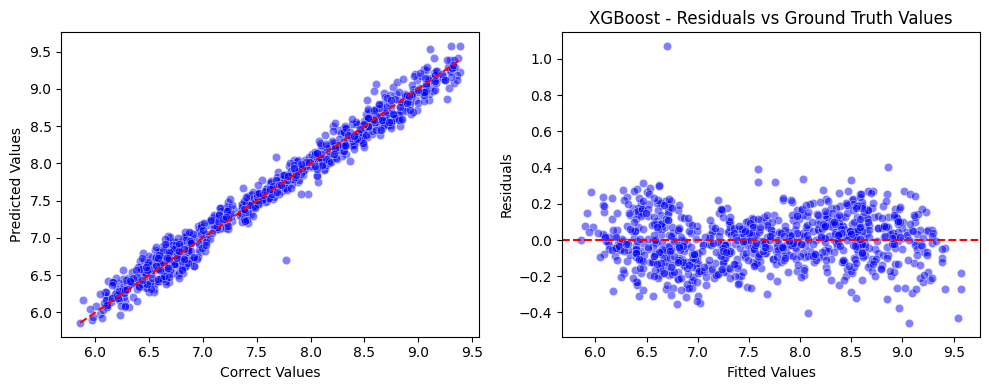

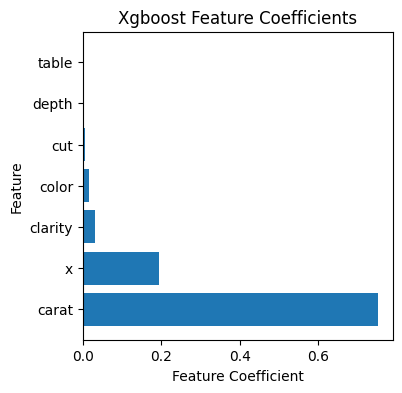

In [ ]:
# Perform grid search and evaluate models
results = {}
import pickle
for name, model in models.items():

    start_time = time.time()
    
    grid_search = GridSearchCV(model, param_grid.get(name), cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Select best hyperparameters
    best_params = grid_search.best_params_
    
    # Train model with best hyperparameters
    best_model = model.set_params(**best_params)
    best_model.fit(X_train, y_train)

    training_time = time.time() - start_time
    
    # Evaluate model
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print('\nResults:')
    results[name] = {'RMSE': rmse, 'R2 Score': r2, 'MAE': mae, 'Training Time': training_time, 'best_params':best_params}
    print(f'{name} - \nRMSE: {rmse}, \nR2 Score: {r2}, \nMAE: {mae}, \nTraining Time: {training_time} seconds, \nbest_params {best_params}' )
    plot(y_test, y_pred_linear,name)

    plot_feature_importance(best_model, FEAT, name )

    # Save the model using pickle
    with open(f'{name}_.pkl', 'wb') as f:
        pickle.dump(model, f)
 

I got carried away with diamonds and wanted to see what performance a quick and simple neural network could achieve on the fly.
For some tasks, pre-neural ML remains the more suitable option in terms of resources, and amount of data.
After some tests, I opted for 70 epochs and a learning rate of 1e-3.


In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


X = X.values
y = y.values
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

 
# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Increased neurons in the first layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Increased dropout rate
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Instantiate the neural network model
model = NeuralNetwork(X_train.shape[1])

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert data to DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train the model
start_time = time.time()
epochs = 70
train_losses = []
test_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    if epoch%20==0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
        
    # Calculate test loss
    with torch.no_grad():
        model.eval()
        y_pred_test = model(X_test)
        test_loss = criterion(y_pred_test.squeeze(), y_test)
        test_losses.append(test_loss.item())
    
training_time = time.time() - start_time

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('\nResults:')
results['Neural Network '] = {'RMSE': rmse, 'R2 Score': r2, 'MAE': mae, 'Training Time': training_time}
print(f'Neural Network   - \nRMSE: {rmse}, \nR2 Score: {r2}, \nMAE: {mae}, \nTraining Time: {training_time} seconds')

# Plot the predicted vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price (Neural Network - PyTorch)')

In [ ]:

# Plot the training and test loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()
